# Signal and Image Processing (SIP_SS25)

### Research Group Neuroinformatics, Faculty of Computer Science,
### University of Vienna


###  Spectral estimation methods Tutorial

Lecturer: Prof. Moritz GROSSE-WENTRUP

Tutorial by: Jakob PRAGER 
$\quad\quad\quad\quad$ Kerim ATAK (kerim.atak@univie.ac.at)

#### Aim: implement several spectral estimation methods and test them on data from a BCI dataset

#### In the lecture we already discussed that it is not trivial how we estimate spectrum of a signal. The naive approach is to just apply a FFT and make a periodogram. The Periodogram however is a poor estimate, as it is prone to a high variance and spectral leakage. There are several ways of adressing these issues. Today we will take a look at:
##### 1. The naive approach: Simple Periodogram <br>
##### 2. Applying a window before <br>
##### 3. Bartlett's method <br>
##### 4. Welch's method <br>
##### 5. Multitapers <br>
#### and test their performance on data that was gathered for Brain computer interfaces (BCIs)

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import scipy as sp

## SSVEP dataset
SSVEP (steady state visually evoked potential) data is gathered from subjects looking at flickering lights at different frequencies. By training a machine learning algorithm to detect the different frequencies one can build [visual keyboards](https://www.youtube.com/watch?v=IcNGKb75oSs).

The dataset consists of data gathered from one subject looking at 20 different frequencies from ~18-15,8 Hz. One sample is 4 seconds long and has a sampling frequency of 250 Hz. To use it with BCIs, the goal could be to train a machine learning classifier to detect if certain frequencies are present in the frequency spectrum. If we want to follow this approach, we should create a fairly accurate depiction of the frequencies in the signal. With this in mind we will now implement different spectral estimation methods.

In [2]:
#load data
data_x = sp.io.loadmat('tutorialdata.mat')['data']
data_y = np.argmax(sp.io.loadmat('tutorialdata.mat')['labels'], axis=1)

N = data_x.shape[1]
fs = 250 #Hz

print(data_x.shape)
print(data_y.shape)

(120, 1000)
(120,)


In [3]:
print(np.unique(data_y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [4]:
def plot_signal(x, y=None, title=None):
    label = 'Frequency Label {}'.format(y) if y is not None else 'Signal'
    plt.figure(figsize=(10, 4))
    plt.plot(x, label=label)
    if title is not None:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()
    
def plot_spectrum(psd_periodogram=None, psd_periodogram_windowed=None, psd_bartlett=None, psd_welch=None, psd_welch_scipy=None, psd_multitaper=None, fs=250):

    _ , ax = plt.subplots(2,3, figsize = (15,12))
        
    if psd_periodogram is not None:
        N = len(psd_periodogram)
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[0,0].plot(freqs[:N//2], psd_periodogram[:N//2])
    ax[0, 0].set_title('Simple Periodogram')
    ax[0, 0].set_xlabel('Frequency (Hz)')
    
    if psd_periodogram_windowed is not None:
        N = len(psd_periodogram_windowed)
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[0,1].plot(freqs[:N//2], psd_periodogram_windowed[:N//2])
    ax[0, 1].set_title('Windowed Periodogram')
    ax[0, 1].set_xlabel('Frequency (Hz)')
    
    if psd_bartlett is not None:
        N = len(psd_bartlett)
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[0,2].plot(freqs[:N//2], psd_bartlett[:N//2])
    ax[0, 2].set_title('Bartlett\'s Method')
    ax[0, 2].set_xlabel('Frequency (Hz)')
    
    if psd_welch is not None:
        N = len(psd_welch)
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[1,0].plot(freqs[:N//2], psd_welch[:N//2])
    ax[1, 0].set_title('Welch\'s Method')
    ax[1, 0].set_xlabel('Frequency (Hz)')
    
    if psd_welch_scipy is not None:
        N = len(psd_welch_scipy)*2
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[1,1].plot(freqs[:N//2], psd_welch_scipy)
    ax[1, 1].set_title('Welch\'s Method (SciPy)')
    ax[1, 1].set_xlabel('Frequency (Hz)')
    
    if psd_multitaper is not None:
        N = len(psd_multitaper)
        freqs = np.fft.fftfreq(N, 1/fs)
        ax[1,2].plot(freqs[:N//2], psd_multitaper[:N//2])
    ax[1, 2].set_title('Multitaper Method')
    ax[1, 2].set_xlabel('Frequency (Hz)')
       
    plt.show()

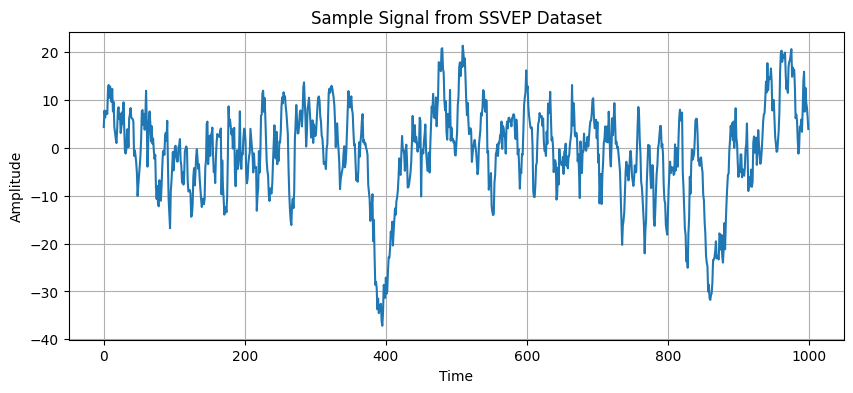

In [5]:
# plot one sample signal of the SSVEP dataset
plot_signal(data_x[20], data_y[20], title='Sample Signal from SSVEP Dataset')

# 1. Simple Periodogram
We don´t apply any 'advanced' spectral estimation methods and just create a periodogram

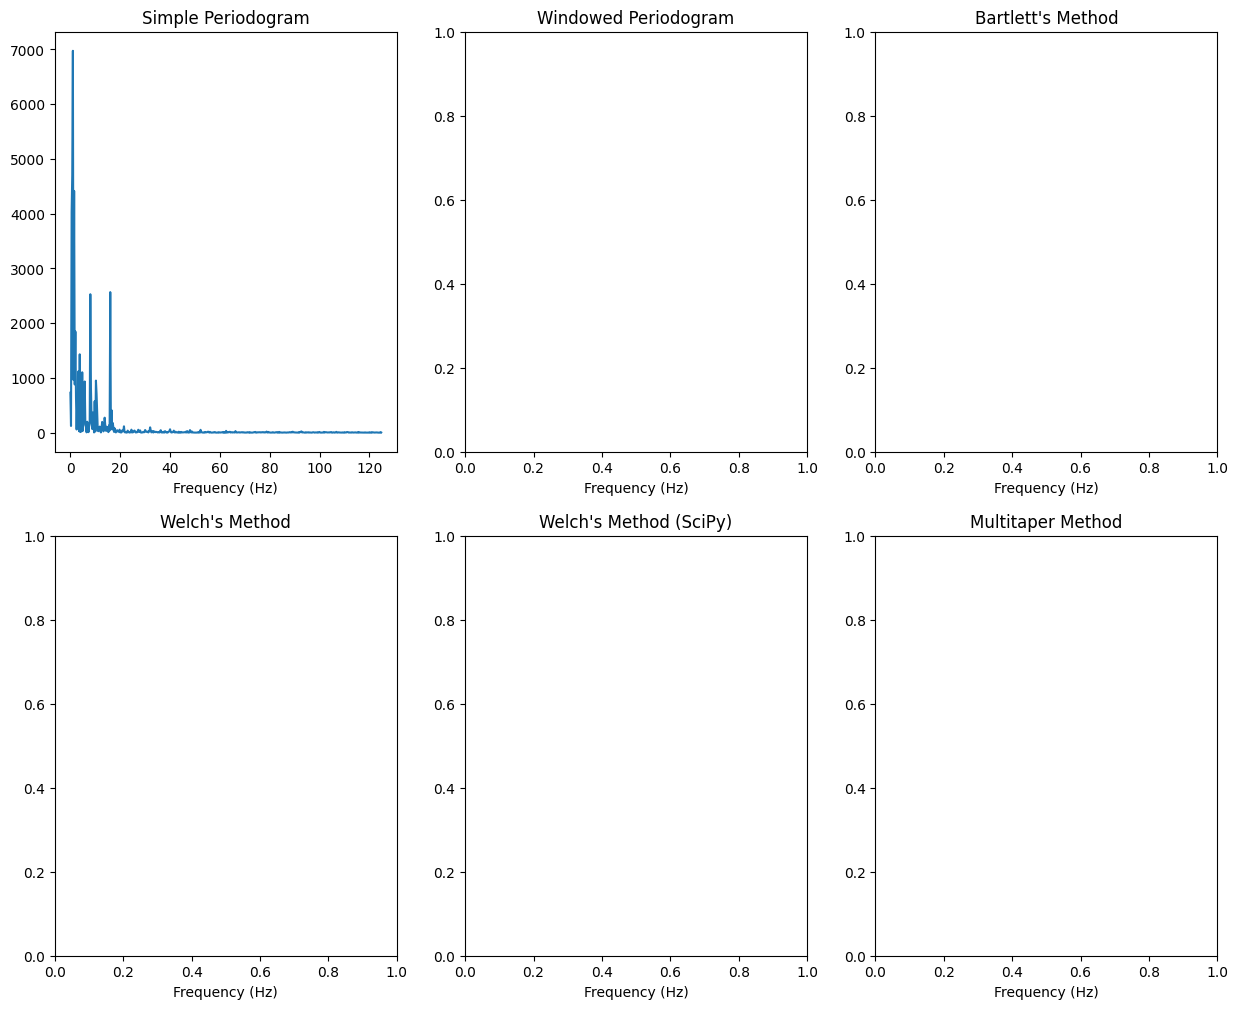

In [6]:
# make an FFT of all samples, take the absolute and square it, normalize by N
# hint: numpy.fft.fft can be applied to whole matrices
psd_periodogram = 1/N * np.abs(np.fft.fft(data_x, axis=1))**2

# plot spectrum
plot_spectrum(psd_periodogram[20])

# 2. Periodogram of windowed signal
Now we can try to apply windows to the samples before making a periodogram. We apply a window to the signal because it reduces spectral leakage by tapering the signal edges, making it more compatible with the DFT's periodicity assumption. We use the function "scipy.signal.windows.get_window" to create the windows. You can get all possible windows on: 
<br>

[link to scipy website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window)

<b>Important Disclaimer! This is not the same "Windowed Periodogram" methods from the lecture 10b!</b>

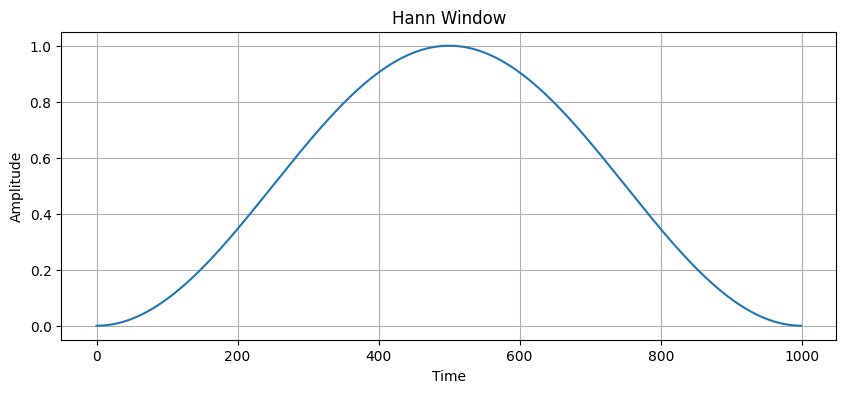

In [7]:
# create windows. Feel free to play around with the type of window used.
window = sp.signal.windows.get_window('hann', N)
plot_signal(window, 0, title='Hann Window')

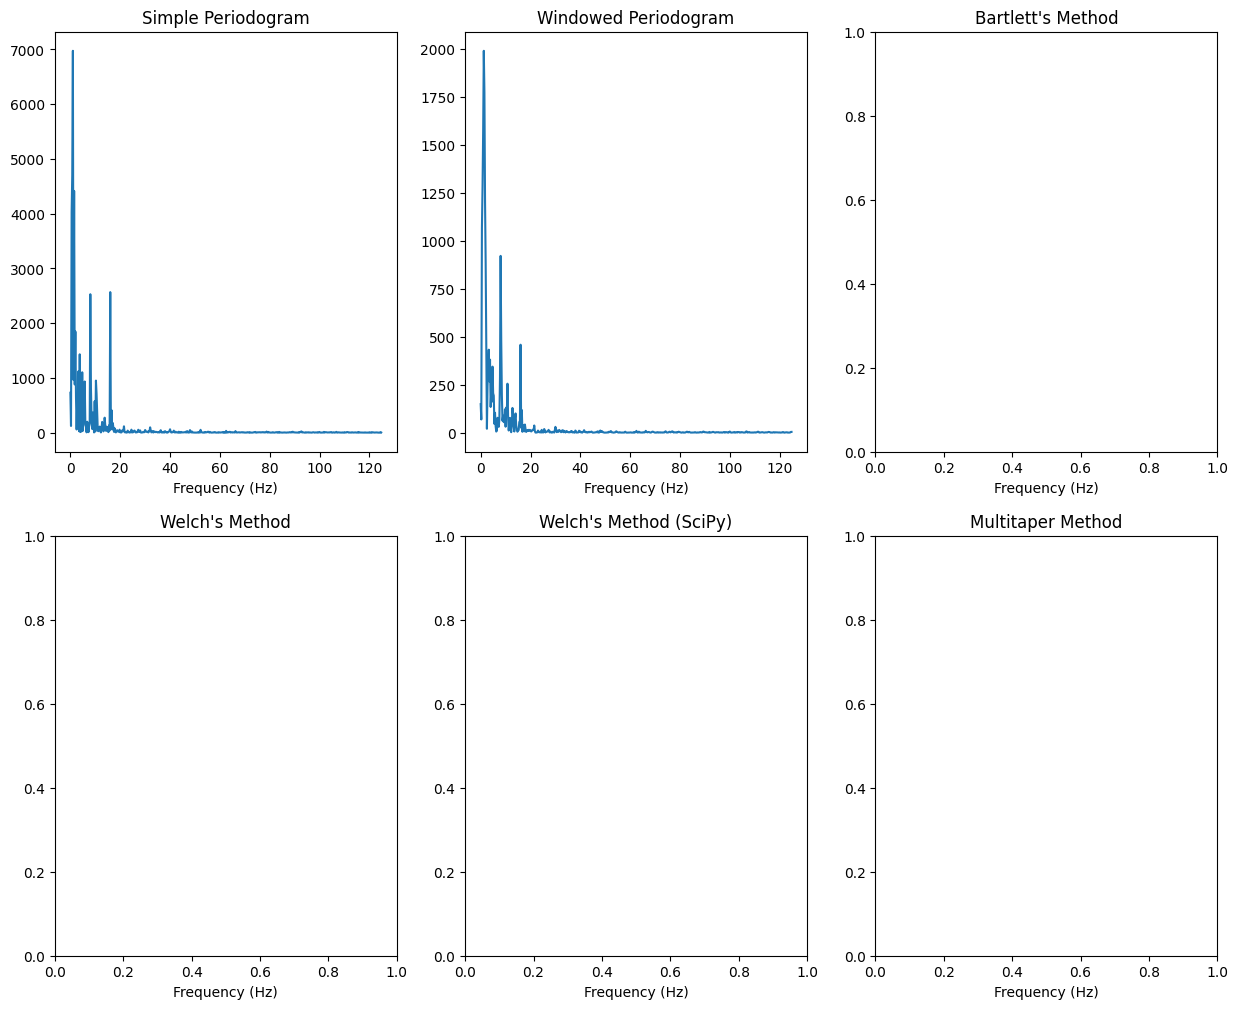

In [8]:
# apply window to all samples
windowed_data_x = data_x * window

# create periodograms from windowed data
psd_periodogram_windowed = 1/N * np.abs(np.fft.fft(windowed_data_x, axis=1))**2

# plot spectrum
plot_spectrum(psd_periodogram[20], psd_periodogram_windowed[20])

# 3. Bartlett's method

Bartlett's method is a classical technique for estimating the power spectral density (PSD) of a random signal. It is based on dividing the signal into non-overlapping segments, applying a window function to each segment, and then averaging the squared magnitudes of the resulting Fourier transforms.

Bartlett's method is particularly useful when dealing with stationary signals, and it provides a simple and intuitive way to estimate the frequency content of a signal.

The PSD estimate using Bartlett's method is given by:

$$\hat{S_B}(w) \quad = \quad \frac{1}{N_1} \sum_{m = 1}^{N_1} \frac{1}{N_2}\Big(\sum_{n=1}^{N_2} x[n+mN_2] \cdot e^{-jwn}\Big)^2$$

In [9]:
# for bartlett's method the variable is the splits. Feel free to play around with it and observe its performance.
splits_of_x = 4

# split data into equal sizes hint: use np.split(). You should have an array of shape (120, splits, N//splits). You might need to reshape it (eg np.transpose).
splitted_data = np.array(np.split(data_x, splits_of_x, axis=1))
print(splitted_data.shape)

splitted_data = np.transpose(splitted_data, (1, 0, 2))
print(splitted_data.shape)

(4, 120, 250)
(120, 4, 250)


(120, 4, 250)
(120, 250)


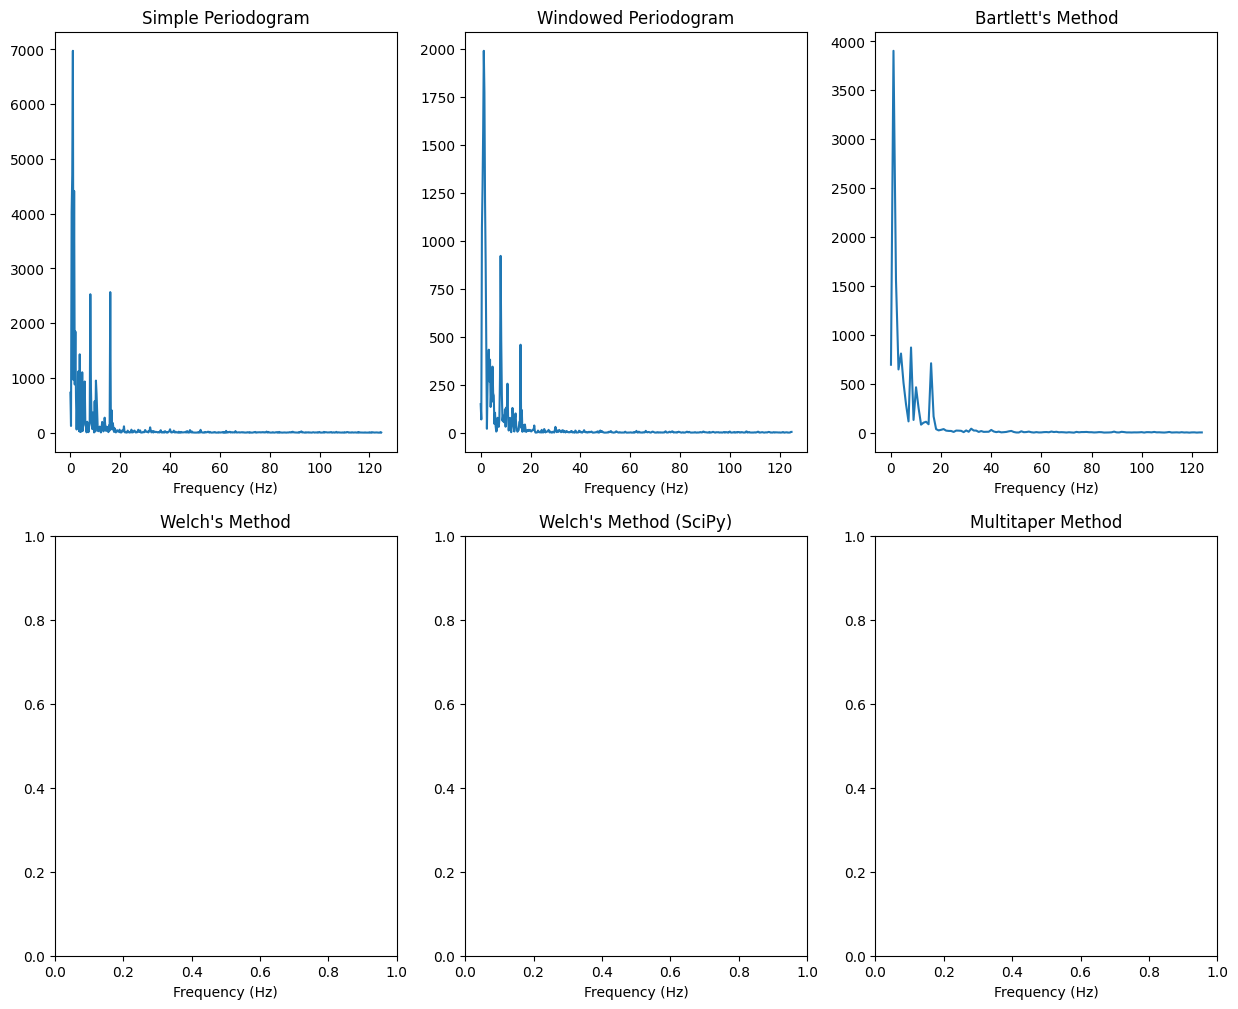

In [10]:
# make a FFT of each signal and square the absolute
psd_bartlett = 1/(N//splits_of_x) * np.abs(np.fft.fft(splitted_data, axis=2))**2
print(psd_bartlett.shape)

# take the mean of the periodograms of the split signals
psd_bartlett = np.mean(psd_bartlett, axis=1)
print(psd_bartlett.shape)

# plot spectra
plot_spectrum(psd_periodogram[20], psd_periodogram_windowed[20], psd_bartlett[20])

# 4. Welch´s method

Welch's method is a spectral estimation technique that improves upon Bartlett's method by introducing overlapping segments. This helps reduce the variance of the spectral estimate compared to Bartlett's method, especially when dealing with short data sequences.

Welch's method involves dividing the signal into overlapping segments, applying a window function to each segment, computing the periodograms, and then averaging them to obtain a smoother and more reliable estimate of the power spectral density.

In [11]:
# welch´s method is a bit more complicated to implement, so we create a function
def welch_method(data_x_, segment_length, noverlap=None):
    ''' 
    Welch's method for estimating the power spectral density (PSD) of a signal.
    
    Parameters:
    data_x_ : array-like, shape (num_signals, num_samples)
        Input signal data, where each row is a signal.
    
    segment_lenght : int
        Length of each segment to be used for the Welch method.
    
    noverlap : int, optional
        Number of overlapping samples between segments. If None, it defaults to half the segment length.
    '''
    welch = []
    
    for x in data_x_:
        splits_of_x = []
        # Calculate the overlap size (often half the length)
        noverlap = segment_length//2 if noverlap is None else noverlap
        # Calculate the step size for the segments
        step_size = segment_length - noverlap
        # Calculate the number of segments
        num_segments = len(x) // (step_size)
        # Iterate to create n splits
        for i in range(num_segments):
            start = i*step_size
            end = start + segment_length
            # Ensure that the end index does not exceed the array length
            if end > len(x):
                break
            splits_of_x.append(x[start:end])
        # create and apply a window and make a periodogram
        splits_of_x = np.array(splits_of_x)
        window = sp.signal.windows.get_window('hann', segment_length)
        windowed_splits_of_x = splits_of_x * window
        periodogram_of_splits = 1/segment_length * np.abs(np.fft.fft(windowed_splits_of_x, axis=1))**2

        # take the mean of the periodograms of the split signals
        psd_welch = np.mean(periodogram_of_splits, axis=0)
        welch.append(psd_welch)

    return np.array(welch)

In [12]:
# feel free to play around with the length of the splits
segment_length = 250
psd_welch = welch_method(data_x, segment_length)
print(psd_welch.shape)

(120, 250)


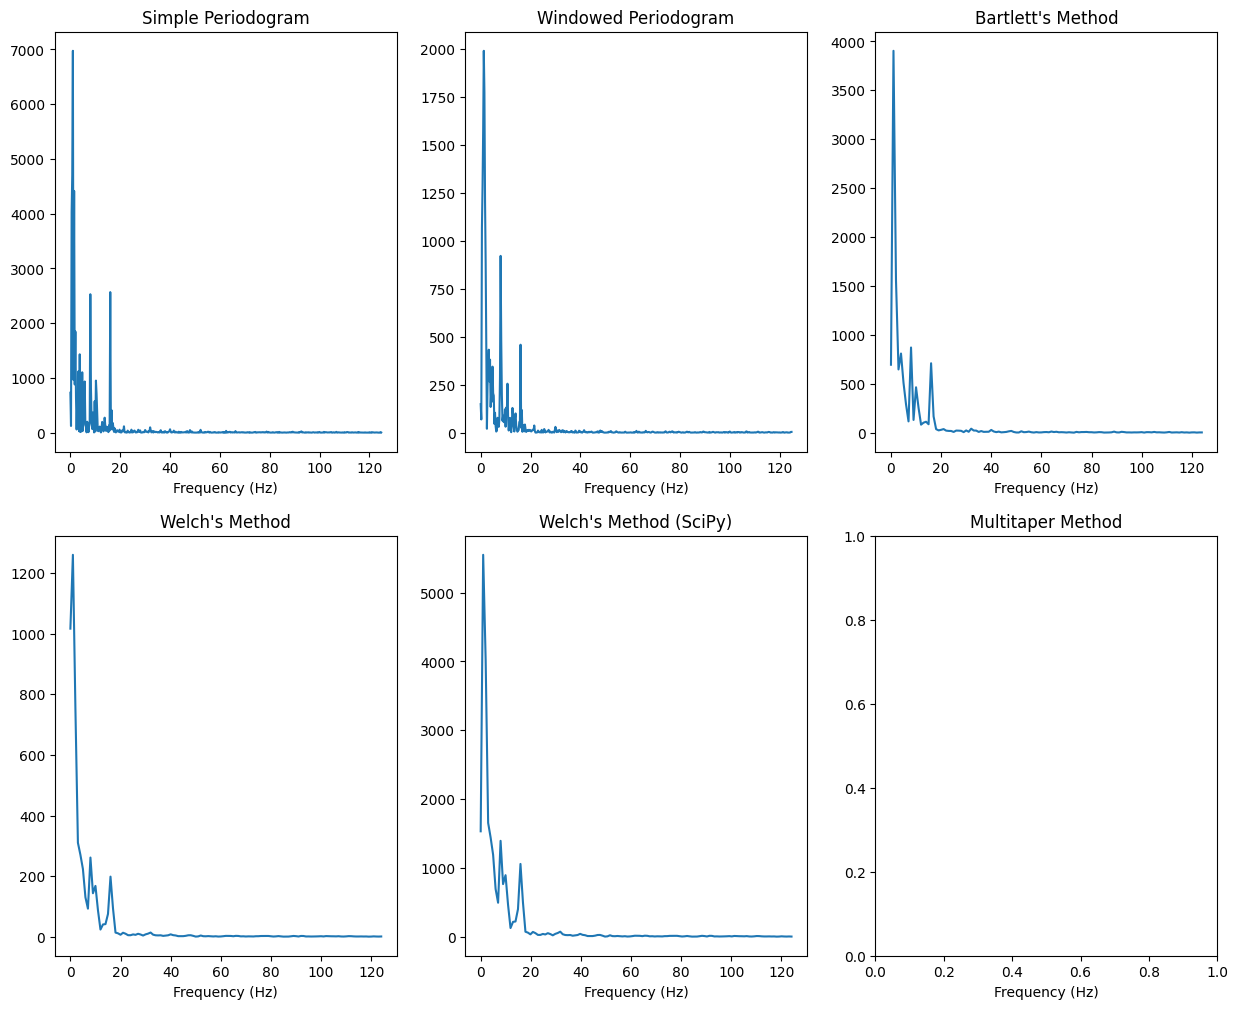

In [13]:
# furthermore, we can test the scipy version of welchs method
f, psd_welch_scipy = sp.signal.welch(data_x, nperseg=segment_length, noverlap=segment_length//2, window='hann')

#plot all spectral estimations up to now
plot_spectrum(psd_periodogram[20], psd_periodogram_windowed[20], psd_bartlett[20], psd_welch[20], psd_welch_scipy[20])

# 5. Multitapers
Multitapers are based on `Discrete prolate Slepian tapers (DPSS sequences)`, also known as `Discrete prolate spheroidal sequences (DPSS)`. DPSS are the solutions to eigenvalue problems that we optimized. 

The aim is to design a set of optimal windows, such that we can smooth or average the  signal spectrum over a bandwidth of $2w_{s}$ which serves as the constraint for our optimization problem.

$$\big|X(w)\big| \quad = \quad \frac{1}{k} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w[k] \cdot x[k] \cdot e^{(-jwn)}\Big|$$

<br>
Visual depiction of multitapers

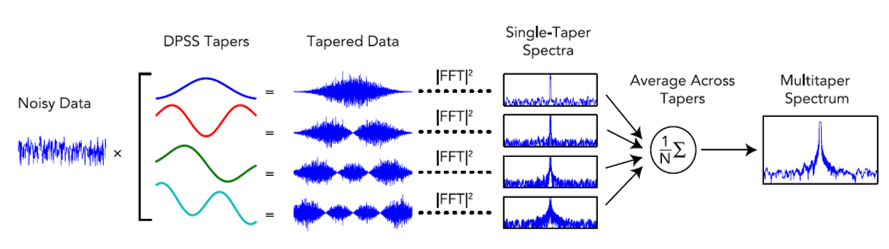

Adapted from [Multitaper toolbox](https://github.com/preraulab/multitaper_toolbox)

Comparison of Multiaper with Periodogram. Adapted from [Power spectral analysis using the adaptation of the multitaper method](https://www.researchgate.net/figure/Power-spectral-analysis-using-the-adaptation-of-the-multitaper-method-a-EEG-wave_fig7_355771173)
<br>
<br>
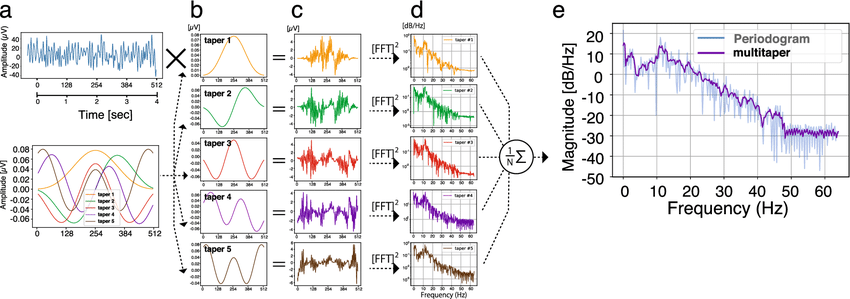

## To compute the multitapers

The expression is a simple multiplication of a window $w[n]$ with our signal $x[n]$; however, the window must be the same length as the original signal.

$$x[n] \cdot w[n]$$



### Parameters

Assuming a signal/window size $w$ ranging from $\left[-\frac{N}{2}, \dots, \frac{N}{2}\right]$, The length of the signal/window is then given as `N+1`.

$w_{s}$ is the allowable bandwidth/threshold at which the multitaper can smoothen our spectrum

$A$ measures the energy concentration of the multitapers

$$\sum_{n=-\frac{N}{2}}^{\frac{N}{2}}\sum_{m=-\frac{N}{2}}^{\frac{N}{2}} \frac{2sin \left(w_{s}(m - n\right))}{m - n}$$

Recall, the solution to the optimization problem is given as
$$A.\vec{w} = \lambda^{'} \vec{w}$$

With matrix decomposition:
$$\vec{w^{T}}A\vec{w} = \lambda^{'}\vec{w^{T}}\vec{w} = \lambda^{'}$$

C:\Users\kerim\AppData\Local\Temp\ipykernel_16084\237321495.py:7: RuntimeWarning: invalid value encountered in divide
  A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])


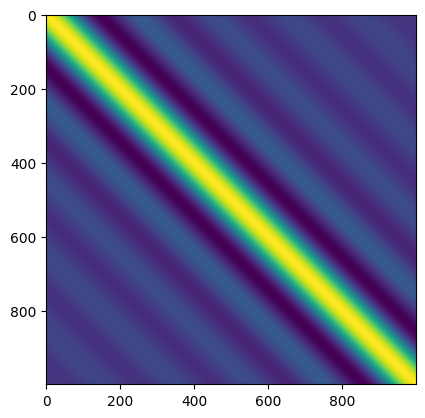

In [14]:
N = data_x.shape[1]  # number of samples
w_s = 0.01*np.pi  # here we selected an allowable threshold of 0.1, this will be tuned afterwards

m = np.arange(N)
n = np.arange(N)

A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])
np.fill_diagonal(A, 2*w_s)

plt.imshow(A)
plt.show()

We filled the diagonals of $A$ with $2w_{s}$ because we encountered some zero division error every time n == m.

To solve this, we need to fill it with the limit of the function as n approaches m using [$\textbf{L'Hôpital's rule}$](https://en.wikipedia.org/wiki/L%27H%C3%B4pital%27s_rule).

Recall from the lecture, we constrained our optimization function with $2w_{s}$

### Compute eigenvectors

Hint: we use np.linalg.eigh(A) because it gives the eigenvectors sorted according to their respective eigenvalue

The eigenvalue plot will enable us to determine the number of eigenvalues that will be useful for selecting eigenvectors (multitapers) for our use.

We are only interested in those multitapers corresponding to eigenvalues with very high energy concentrations. In simple terms, selecting those eigenvectors means we only consider multitapers with the highest energy concentration.

For the sake of demonstration, I defined a variable `count` as the number of eigenvalues selected and plotted them in red color.

#### Note: You can toy around with the choice of `count`.

In [15]:
eig_values, eig_vectors = np.linalg.eigh(A)
print(eig_values.shape, eig_vectors.shape)

(1000,) (1000, 1000)


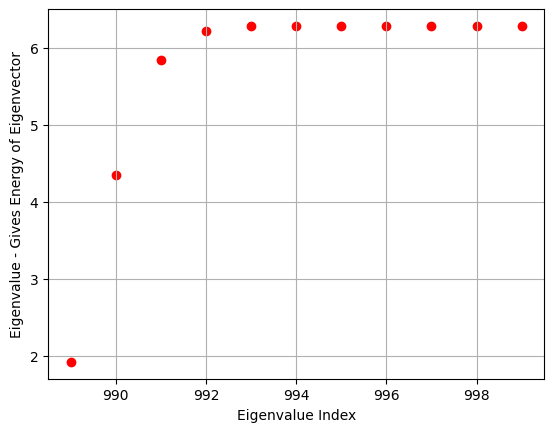

In [16]:
count = 11

# plot the number of eigenvalues selected and observe their values
plt.scatter(range(N - count, N), np.abs(eig_values[-count:]), color='red')
plt.grid()
plt.ylabel('Eigenvalue - Gives Energy of Eigenvector')
plt.xlabel('Eigenvalue Index')
# plt.ylim(-0.1, 1.1)
plt.show()

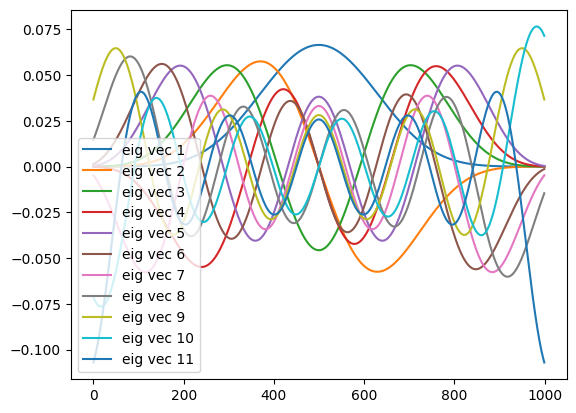

In [17]:
# plot eigen vecors
for i in range(1,count+1):
    plt.plot(eig_vectors[:,-i],label=f'eig vec {i}')
    plt.legend()

From the plot, we can see that the multitapers are orthogonal and mutually uncorrelated to one another. The first multitaper (with only the first eigenvector) looks precisely Gaussian, and the second one appears as a derivative of the first, and so on. These are not coincidences but rather show the orthogonality of the multitapers. All the individual orthogonal multitapers will then work together as a sequence. The aim is that each of these multitapers will capture or highlight different features in the data.

Now, we can check the efficiency of our selected number of multitapers by taking the Fourier Transform as described below. The efficiency is measured by how the overall multitaper approximates a rectangular window.

$$|X(w)| = \frac{1}{K} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w_k[n] \cdot x[n] \cdot e^{(-jwn)}\Big|$$



(120, 1000)


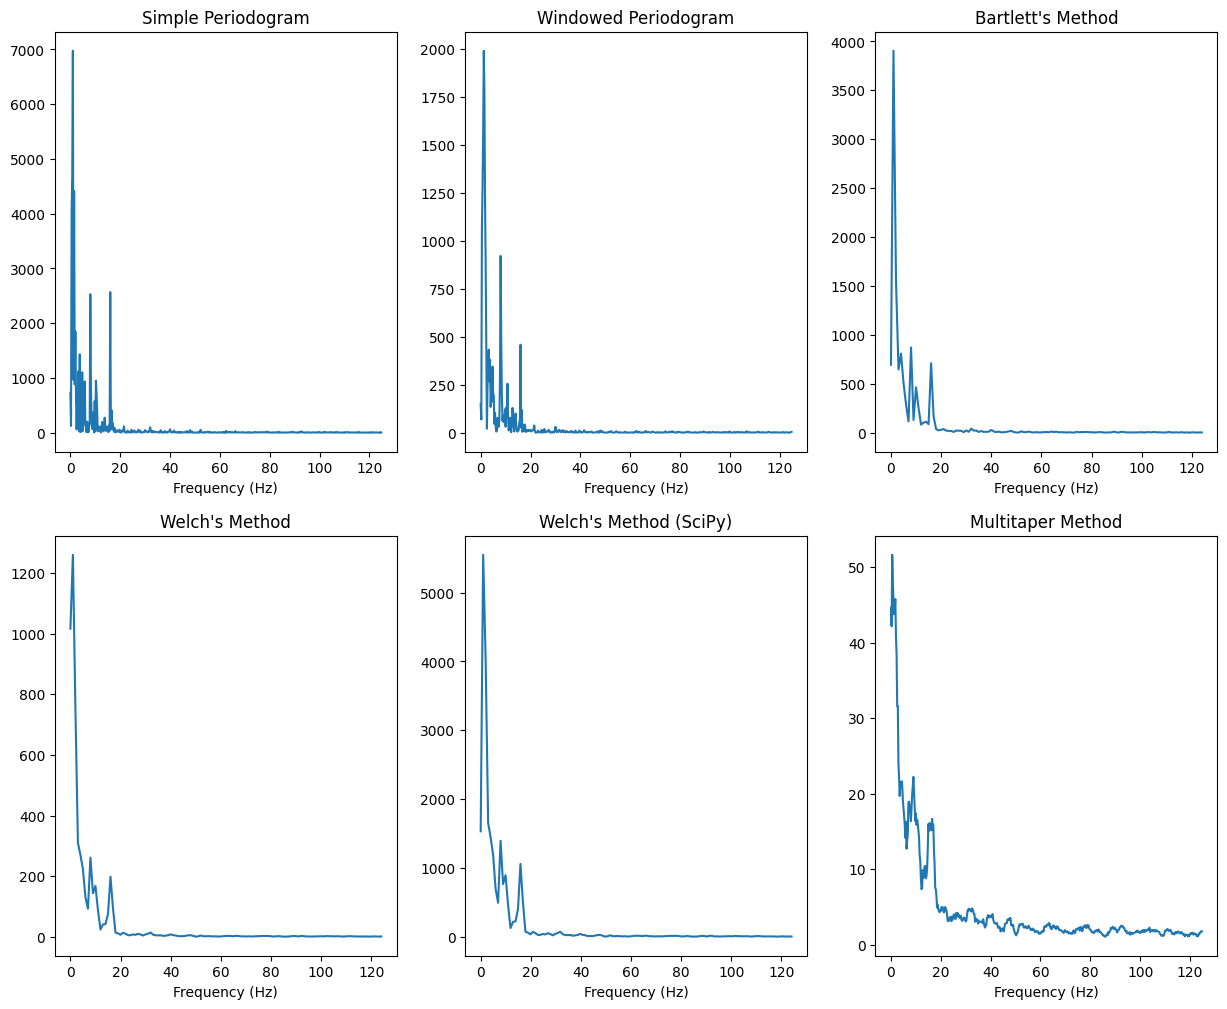

In [18]:
#from scipy.fft import fft, fftfreq, ifft
psd_multitaper = []

# loop over eigenvectors to multiplicate them with the data
# you can change the number of tapers used by changing the range
for i in range(1,count):
     psd_multitaper.append(np.abs(np.fft.fft(data_x*eig_vectors[:,-i],axis=1)))
     
psd_multitaper = np.array(psd_multitaper)

# take the mean of all tapers
psd_multitaper = np.mean(psd_multitaper, axis=0)
print(psd_multitaper.shape)

# plot all spectral estimations up to now
plot_spectrum(psd_periodogram[20], psd_periodogram_windowed[20], psd_bartlett[20], psd_welch[20], psd_welch_scipy[20], psd_multitaper[20])

# Test performance of spectral estimation
#### We can now train a support vector classifier (SVC) for each spectral estimation method and test how well it can predict unseen data.

#### In this case we use a SVC for the sake of simplicity. While a CNN might perform better generally, we don´t need to achieve perfect classification accuracy but want to explore the differences between spectral estimation techniques.

('No window', 0.375)
('Window', 0.35)
('multitapers', 0.45)
('bartletts method', 0.525)
('welchs method', 0.525)
('welch(sicpy)', 0.525)


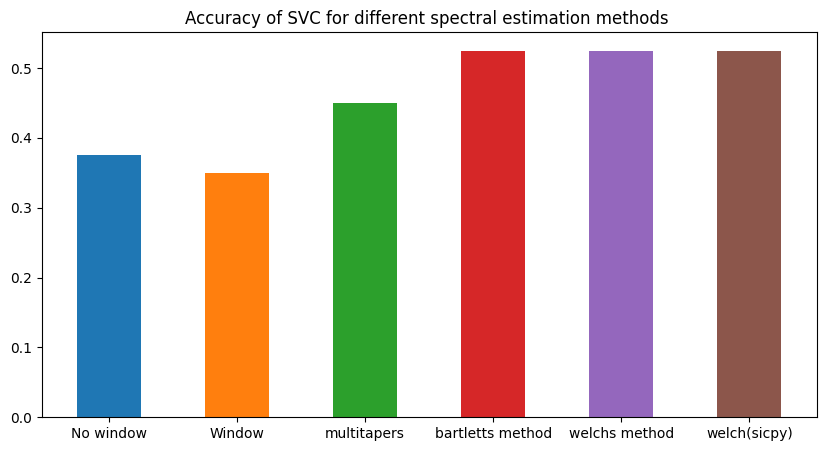

In [19]:
# create a library to iterate over them
methods = {"No window":psd_periodogram,"Window":psd_periodogram_windowed,"multitapers" :psd_multitaper,  'bartletts method' : psd_bartlett, "welchs method" :psd_welch,"welch(sicpy)" :psd_welch_scipy}

#initialize figure for plotting
plt.figure(figsize=(10,5))
plt.title('Accuracy of SVC for different spectral estimation methods ')

#iterate over all methods and train a SVC on the samples
for method in methods:
    # split data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(methods[method], data_y, test_size=0.33, random_state=42)
    # we scale the data and train a SVC
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    pipe.fit(X_train, y_train).score(X_test, y_test)
    score = pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)

    #print results
    print((method, score))
    #visualize results
    plt.bar(method,score, width=0.5)


